# **Tutorial 4 SpatialEx+ Enables Spatial Multi-omics through Omics Diagonal Integration (transcriptomics-proteomics)**

The protein expression in Rep1 was preprocessed in another study, citation is here: 📄
<a href="https://doi.org/10.1101/2024.12.05.626986">NicheTrans</a>.

And you can find the corresponding data here: 🔗 
[Zenodo](https://zenodo.org/records/15706278).

In [12]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpatialEx as se

device = 'cuda:3'

## 1. Prepare the dataset

### Arange your dataset folder as below:
```
datasets/
│
├── Human_Breast_Cancer_Rep1/                       # The 1st Slice
│   ├── cell_protein_matrix.h5ad                          
│   ├── cell.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif          
│   └── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv
│   └── HBRC_Rep1_cell_coor.csv
│   └── HBRC_Rep1_Out_uni.npy
│
├── Human_Breast_Cancer_Rep2/                       # The 2nd Slice
│   ├── cell_feature_matrix.h5
│   ├── cell.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif        
│   └── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv
│   └── HBRC_Rep2_cell_coor.csv
│   └── HBRC_Rep2_Out_uni.npy
```

### 1.1 Preprocess Slice 1, Rep1 protein

In [ ]:
resolution = 64
save_root = '/home/wcy/code/datasets/Xenium/'
sample_name1 = 'Human_Breast_Cancer_Rep1'
sample_name2 = 'Human_Breast_Cancer_Rep2'

In [3]:
file_path1 = save_root + sample_name1 + '/cell_protein_matrix.h5ad'                     # Note: not 'cell_feature_matrix.h5'
obs_path1 = save_root + sample_name1 + '/cells.csv'
img_path1 = save_root + sample_name1 + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
transform_mtx_path1 = save_root + sample_name1 + '/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'

adata1 = sc.read_h5ad(file_path1)
adata1.var_names = adata1.var_names.astype(str)
adata1.obs_names = adata1.obs_names.astype(str)
obs = pd.read_csv(obs_path1, index_col=0)
obs.index = obs.index.astype(str)
adata1 = adata1[obs.index]
adata1.obs = obs
adata1.obsm['spatial'] = adata1.obs[['x_centroid', 'y_centroid']].values
adata1.var_names_make_unique()
sc.pp.scale(adata1)

img, scale = se.pp.Read_HE_image(img_path1)
trans_mtx = pd.read_csv(transform_mtx_path1, header=None).values
adata1 = se.pp.Register_physical_to_pixel(adata1, trans_mtx, scale)
he_patches, adata1 = se.pp.Tiling_HE_patches(resolution, adata1, img)
adata1 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata1, image_encoder='uni', device=device)   

======================== Tiling HE patches for each single cells ===========================
patch radius is  32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167780/167780 [00:03<00:00, 43773.49it/s]


======================== Tiling HE patches for each single cells ===========================
patch radius is  32
Remove the outlier cells, and Anndata file was reduced!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111555/111555 [00:02<00:00, 47517.18it/s]


### 1.2 Preprocess Slice 2, Rep2 transcriptomics

In [ ]:
file_path2 = save_root + sample_name2 + '/cell_feature_matrix.h5'
obs_path2 = save_root + sample_name2 + '/cells.csv'
img_path2 = save_root + sample_name2 + '/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
transform_mtx_path2 = save_root + sample_name2 + '/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv'

adata2 = se.pp.Read_Xenium(file_path2, obs_path2)
adata2 = se.pp.Preprocess_adata(adata2)                                              

img, scale = se.pp.Read_HE_image(img_path2)
transform_mtx = pd.read_csv(transform_mtx_path2, header=None).values
adata2 = se.pp.Register_physical_to_pixel(adata2, transform_mtx, scale=scale)
he_patches, adata2 = se.pp.Tiling_HE_patches(resolution, adata2, img)
adata2 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata2, image_encoder='uni', device=device)

## 2. Train SpatialEx+

### 2.1 Within the squencing area

In [4]:
num_neighbors = 7

graph1 = se.pp.Build_hypergraph_spatial_and_HE(adata1, num_neighbors, graph_kind='spatial', return_type='crs')
graph2 = se.pp.Build_hypergraph_spatial_and_HE(adata2, num_neighbors, graph_kind='spatial', return_type='crs')

spatialexp = se.SpatialExP(adata1, adata2, graph1, graph2, device=device, epochs=500)
spatialexp.train()
panelB1 = spatialexp.inference_direct(adata1.obsm['he'], graph1, panel='panelB')
panelA2 = spatialexp.inference_indirect(adata2.obsm['he'], graph2, panel='panelA')



=================================== Start training =========================================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:30<00:00,  1.51it/s]


### 2.2 Outside the squencing area

In [5]:
out_spatial1 = pd.read_csv(save_root + sample_name1 + '/HBRC_Rep1_cell_coor.csv', index_col=0)
out_spatial2 = pd.read_csv(save_root + sample_name2 + '/HBRC_Rep2_cell_coor.csv', index_col=0)
out_he1 = np.load(save_root + sample_name1 + '/HBRC_Rep1_Out_uni.npy')
out_he2 = np.load(save_root + sample_name2 + '/HBRC_Rep2_Out_uni.npy')

graph1 = se.pp.Build_hypergraph(out_spatial1.values, num_neighbors=num_neighbors, normalize=True)
graph2 = se.pp.Build_hypergraph(out_spatial2.values, num_neighbors=num_neighbors, normalize=True)

panelA1_out = spatialexp.inference_indirect(out_he1, graph1, panel='panelA')
panelA2_out = spatialexp.inference_indirect(out_he2, graph2, panel='panelA')
panelB1_out = spatialexp.inference_direct(out_he1, graph1, panel='panelB')
panelB2_out = spatialexp.inference_direct(out_he2, graph2, panel='panelB')

## 3. Evaluation

### 3.1 Quantatitive metrics

In [9]:
file_path1_gt = save_root + sample_name1 + '/cell_feature_matrix.h5'
obs_path1_gt = save_root + sample_name1 + '/cells.csv'
adata1_gt = se.pp.Read_Xenium(file_path1_gt, obs_path1_gt)[adata1.obs_names]
adata1_gt = se.pp.Preprocess_adata(adata1_gt, cell_mRNA_cutoff=0)   

graph = se.pp.Build_graph(adata1_gt.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='coo')
pcc, pcc_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='pcc')
ssim, ssim_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='ssim', graph=graph)
cmd, cmd_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='cmd')
print('Evaluation of the Slice 1 in gene-level, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)

x shape is  167780
cell number is less than 200000
Evaluation of the Slice 1 in gene-level, PCC:  0.24094003  SSIM:  0.3908345917668196  CMD:  0.23311009640918512


### 3.2 Visualization

#### 3.2.1 Rep1

In [10]:
outx, outy = out_spatial1['image_col'].values, out_spatial1['image_row'].values
innerx, innery = adata1.obsm['image_coor'][:, 0], adata1.obsm['image_coor'][:, 1]
boundary_func, y_estimate = se.utils.Estimate_boundary(innerx, innery)
y_boundary = boundary_func(outx) - 100
selection1 = (outx<innerx.min()+50) + (outx>innerx.max()-50) + (outy<innery.min()+50)
selection2 = (outx>innerx.min()) & (outx<innerx.max()) & (outy>y_boundary)
selection = selection1 + selection2

Estimating y boundary


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 2986.93it/s]


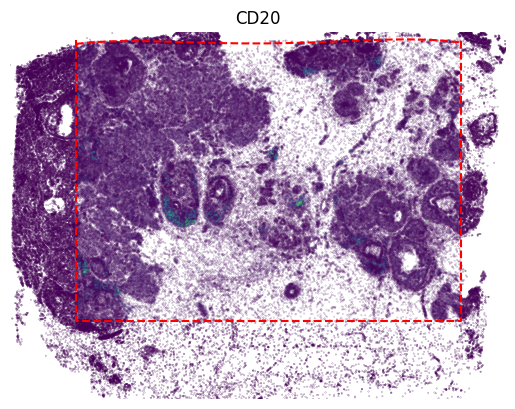

In [13]:
protein_name = 'CD20'
protein_idx = np.where(adata1.var_names == protein_name)[0]
vmin, vmax = adata1[:, protein_name].X.min(), adata1[:, protein_name].X.max()

value = adata1[:, protein_name].X
x, y = adata1.obsm['image_coor'][:, 0], adata1.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, s=0.01)  

value = panelA1_out[:, protein_idx]
x, y = out_spatial1['image_col'], out_spatial1['image_row']
plt.scatter(x[selection], y[selection], c=value[selection], vmax=vmax, s=0.02)

plt.plot(np.arange(innerx.min(), innerx.max()), boundary_func(np.arange(innerx.min(), innerx.max())), color='red', linestyle='--')
plt.plot([innerx.min(), innerx.min(), innerx.max(), innerx.max()], [innery.max(), innery.min(), innery.min(), innery.max()], 
         color='red', linestyle='--')

plt.title(protein_name)
plt.xlim((x.min(),x.max()))
plt.ylim((y.min(),y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

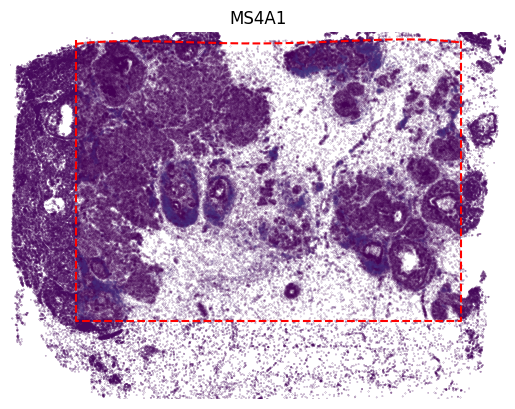

In [14]:
gene_name = 'MS4A1'
gene_idx = np.where(adata2.var_names == gene_name)[0]
vmin, vmax = adata2[:, gene_name].X.min(), adata2[:, gene_name].X.max()

value = panelB1[:, gene_idx]
x, y = adata1.obsm['image_coor'][:, 0], adata1.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmin=0, vmax=vmax, s=0.01)  

value = panelB1_out[:, gene_idx]
x, y = out_spatial1['image_col'], out_spatial1['image_row']
plt.scatter(x[selection], y[selection], c=value[selection], vmin=0, vmax=vmax, s=0.02)

plt.plot(np.arange(innerx.min(), innerx.max()), boundary_func(np.arange(innerx.min(), innerx.max())), color='red', linestyle='--')
plt.plot([innerx.min(), innerx.min(), innerx.max(), innerx.max()], [innery.max(), innery.min(), innery.min(), innery.max()], 
         color='red', linestyle='--')

plt.title(gene_name)
plt.xlim((x.min(),x.max()))
plt.ylim((y.min(),y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

#### 3.2.2 Rep2

In [15]:
col_min, col_max = adata2.obsm['image_coor'][:, 1].min(), adata2.obsm['image_coor'][:, 1].max()
row_min, row_max = adata2.obsm['image_coor'][:, 0].min(), adata2.obsm['image_coor'][:, 0].max()
selection = (out_spatial2['image_row'] > row_min) & (out_spatial2['image_row'] < row_max) & (out_spatial2['image_col'] > col_min) & (out_spatial2['image_col'] < col_max)
obs_inner = out_spatial2[selection]
var_names = adata1.var_names

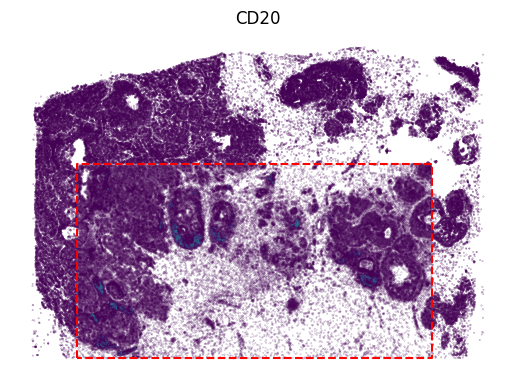

In [17]:
protein_name = 'CD20'
gene_idx = np.where(adata1.var_names == protein_name)[0]
vmin, vmax = adata1[:, protein_name].X.min(), adata1[:, protein_name].X.max()

value = panelA2[:, gene_idx]
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmin=vmin+1, vmax=vmax, s=0.01)  

value = panelA2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], vmax=vmax, s=0.02)

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

plt.title(protein_name)
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

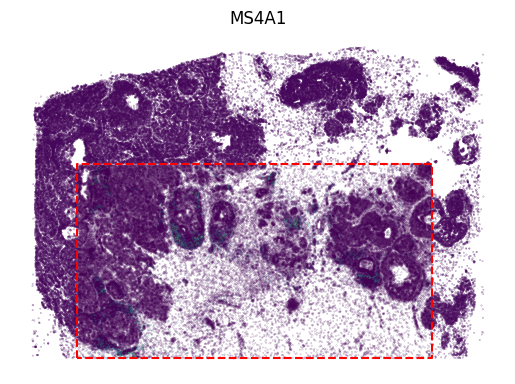

In [20]:
gene_name = 'MS4A1'
gene_idx = np.where(adata2.var_names == gene_name)[0]

value = adata2[:, gene_name].X
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmin=0, s=0.01)  

value = panelB2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], vmin=0, vmax=vmax, s=0.02)

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

plt.title(gene_name)
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()